Image Fusion using OpenCV

In [1]:
import cv2 as cv
import numpy as np
import pywt 
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from skimage.measure import shannon_entropy

In [2]:
# panchromatic + multispectral
img1 = cv.imread('./Assets/samples/bunker/img1.bmp') 
img2 = cv.imread('./Assets/samples/bunker/img2.bmp') 
img3 = cv.imread('./Assets/samples/bunker/img3.bmp')

# multitemporal
acet1 = cv.imread('./Assets/samples/acet1.jpg')
acet2 = cv.imread('./Assets/samples/acet2.jpg')

# multifocus
focus1 = cv.imread('./Assets/samples/focus1.png')
focus2 = cv.imread('./Assets/samples/focus2.png')

# brain1 = cv.imread('./Assets/samples/scan1.jpg')
# brain2 = cv.imread('./Assets/samples/scan2.jpg')

# marne1 = cv.imread('./Assets/samples/marne1.bmp')
# marne2 = cv.imread('./Assets/samples/marne2.bmp')
# marne3 = cv.imread('./Assets/samples/marne3.bmp')
# marne4 = cv.imread('./Assets/samples/marne4.bmp')

# marne22 = cv.imread('./Assets/samples/marne22.bmp')
# marne21 = cv.imread('./Assets/samples/marne21.bmp')

child1 = cv.imread('./Assets/samples/child1.png')
child2 = cv.imread('./Assets/samples/child2.png')
child3 = cv.imread('./Assets/samples/child3.png')

Spatial Domain Techniques for Image Fusion

In [3]:
# alpha represents weight of first image
# set alpha = 0.5 for unweighted average

def weightedFusion(image1, image2, alpha):
    
    dst = cv.addWeighted(image1, alpha, image2, 1 - alpha, 0.0)
    
    cv.imwrite('saved.bmp', dst)

In [4]:
# alpha represents weight of first image

def hsvFusion(image1, image2, alpha):

    tmp1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY, dstCn = 1)
    tmp2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY, dstCn = 1)

    hsv_image = cv.cvtColor(image2, cv.COLOR_BGR2HSV)
    hsv_channels = cv.split(hsv_image)

    res_channel = cv.addWeighted(tmp1, alpha, tmp2, 1-alpha, 0.0)

    dst = cv.merge([hsv_channels[0], hsv_channels[1], res_channel])
    dst = cv.cvtColor(dst, cv.COLOR_HSV2BGR)

    cv.imwrite('saved.bmp', dst)

In [5]:
# finding weights by feature extraction using PCA 

def pcaFusion(image1, image2):
    
    sz = image1.shape

    data = np.zeros((sz[0]*sz[1]*sz[2], 2))
    data[:, 0] = image1.flatten()
    data[:, 1] = image2.flatten()

    mean, eigenvectors, eigenvalues = cv.PCACompute2(data, mean=None)
    if(eigenvalues[0][0] > eigenvalues[1][0]):
        eg = 0
    else:
        eg = 1
        
    ref = abs(eigenvectors[eg])
    s = np.sum(ref)
    dst = (ref[0] * image1 + ref[1] * image2)

    cv.imwrite('saved.bmp', dst)

Frequency Domain Techniques for Image Fusion

In [6]:
# laplacian pyramid for merging and fusion of images

def generateGaussian(img, n):
    gD = img.copy()
    gPimg = [gD]
    for i in range(n):
        gD = cv.pyrDown(gD)
        gPimg.append(gD)
    
    return gPimg

def generateLaplace(gPimg, n):
    lPimg = [gPimg[n]]
    for i in range(n, 0, -1):
        r,c,ch = gPimg[i-1].shape

        gU = cv.pyrUp(gPimg[i])
        gU = gU[:r, :c]
        
        lP = cv.subtract(gPimg[i-1], gU)
        lPimg.append(lP)
    
    return lPimg

def weightedAvg(lPA, lPB, alpha):
    LS = []
    for la, lb in zip(lPA, lPB):
        ls = cv.addWeighted(la, alpha, lb, 1-alpha, 0.0)
        LS.append(ls)
    
    res = LS[0]
    for i in range(1, len(lPA)):
        r,c,ch = LS[i].shape

        res = cv.pyrUp(res)
        res = res[:r, :c]

        res = cv.add(res, LS[i])

    return res

def merge(lPA, lPB, ratio):
    LS = []
    for la, lb in zip(lPA, lPB):
        rows, cols, ch = la.shape
        ls = np.hstack((la[:, 0:cols//ratio], lb[:, cols//ratio:]))
        LS.append(ls)
    
    res = LS[0]
    for i in range(1, len(lPA)):
        res = cv.pyrUp(res)
        res = cv.add(res, LS[i])

    return res


def laplaceFusion(image1, image2, alpha, n):
    gPA = generateGaussian(image1, n)
    gPB = generateGaussian(image2, n)

    lPA = generateLaplace(gPA, n-1)
    lPB = generateLaplace(gPB, n-1)

    # change function here
    
    # dst = merge(lPA, lPB, alpha)
    dst = weightedAvg(lPA, lPB, alpha)

    cv.imwrite('saved.bmp', dst)


In [7]:
# discrete Cosine/Fourier tranform for fusion of images

def dctFusion(image1, image2):
    b1, g1, r1 = cv.split(image1)
    tmpB1, tmpG1, tmpR1 = cv.dct(np.float32(b1)), cv.dct(np.float32(g1)), cv.dct(np.float32(r1))

    b2, g2, r2 = cv.split(image2)
    tmpB2, tmpG2, tmpR2 = cv.dct(np.float32(b2)), cv.dct(np.float32(g2)), cv.dct(np.float32(r2))
    
    B = cv.idct(cv.addWeighted(tmpB1, 0.7, tmpB2, 0.3, 0.0))
    G = cv.idct(cv.addWeighted(tmpG1, 0.7, tmpG2, 0.3, 0.0))
    R = cv.idct(cv.addWeighted(tmpR1, 0.7, tmpR2, 0.3, 0.0))
    
    dst = cv.merge((B, G, R))

    cv.imwrite('saved.bmp', dst)

In [8]:
# Discrete Wavelet tranform for fusion (without masking)

def preDWT(image):
    b, g, r = cv.split(image)
    coeffB, coeffG, coeffR = pywt.dwt2(b, 'haar'), pywt.dwt2(g, 'haar'), pywt.dwt2(r, 'haar')
    return [coeffB, coeffG, coeffR]

def dwtFusion(image1, image2):
    arr1 = preDWT(image1)
    arr2 = preDWT(image2)
    
    arr = []
    for coeff1, coeff2 in zip(arr1, arr2):
        cA = cv.addWeighted(coeff1[0], 0.5, coeff2[0], 0.5, 0.0)
        cD = []
        for cD1, cD2 in zip(coeff1[1], coeff2[1]):
            cD.append(np.maximum(cD1, cD2))
        arr.append([cA, cD])
    
    res = []
    for coeff in arr:
        d = pywt.idwt2(coeff, 'haar')
        res.append(d)
    
    dst = cv.merge(res)
    
    cv.imwrite('saved.bmp', dst)


Performance Evaluation

In [9]:
def PSNR(original, fused):
    original = cv.resize(original, (fused.shape[1], fused.shape[0]))
    
    return peak_signal_noise_ratio(original, fused)

def MSE(original, fused):
    original = cv.resize(original, (fused.shape[1], fused.shape[0]))
    
    return mean_squared_error(original, fused)

def SSIM(original, fused):
    original = cv.resize(original, (fused.shape[1], fused.shape[0]))

    original = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
    fused = cv.cvtColor(fused, cv.COLOR_BGR2GRAY)

    score, diff = structural_similarity(original, fused, full=True)
    
    return score

def ENT(fused):
    return shannon_entropy(fused)

Peak Signal to Noise Ratio: 16.72479813938344
Mean Squared Error: 1382.2943947000672
Structural Similarity: 0.7755745385406664
Entropy: 7.4112775768633545


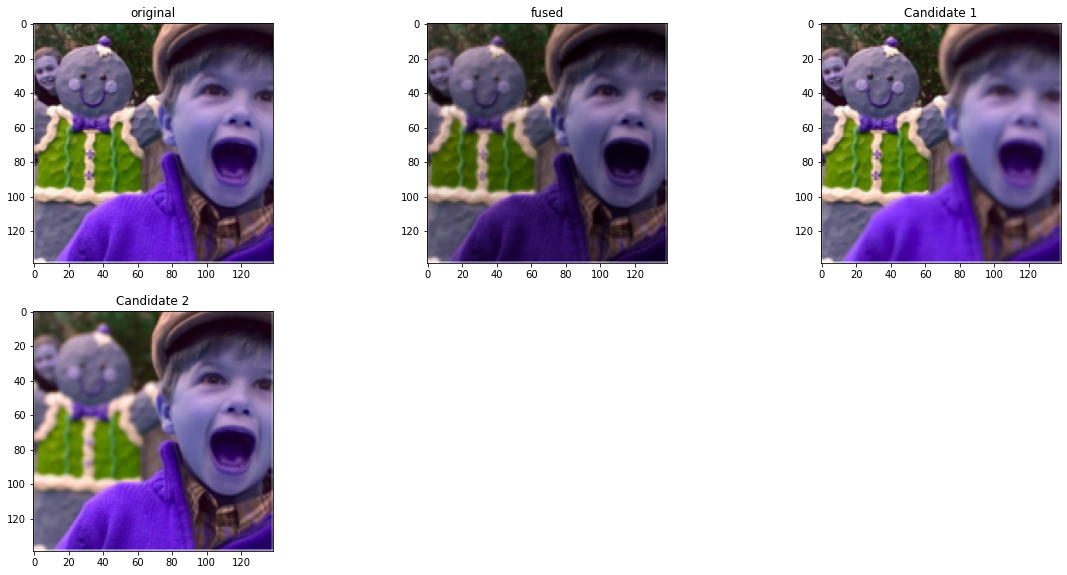

In [10]:
def readImg(image1, image2):
    
    # set function here
    hsvFusion(image1, image2, 0.5)
    dst = cv.imread('./saved.bmp')

    return dst

def plotImages(arr):
    fig = plt.figure(figsize=(20,15))

    fig.add_subplot(3, 3, 1)
    plt.imshow(arr[0])
    plt.title('original')

    fig.add_subplot(3, 3, 2)
    plt.imshow(arr[1])
    plt.title('fused')
    
    fig.add_subplot(3, 3, 3)
    plt.imshow(arr[2])
    plt.title('Candidate 1')
    
    fig.add_subplot(3, 3, 4)
    plt.imshow(arr[3])
    plt.title('Candidate 2')

def caller(original, image1, image2):
    dst = readImg(image1, image2)
    return [original, dst, image1, image2]

arr = caller(child1, child2, child3)

print('Peak Signal to Noise Ratio:', PSNR(arr[0], arr[1]))
print('Mean Squared Error:', MSE(arr[0], arr[1]))
print('Structural Similarity:', SSIM(arr[0], arr[1]))
print('Entropy:', ENT(arr[1]))
plotImages(arr)